In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
!mkdir -p ~/.kaggle
!cp "/content/gdrive/My Drive/kaggleJson/kaggle.json" ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [3]:
# !kaggle datasets download -d masud1901/mosquito-dataset-for-image-classification
# !unzip mosquito-dataset-for-image-classification.zip

In [4]:
!kaggle datasets download -d masud1901/mosquito-dataset-for-classification-cnn
!unzip mosquito-dataset-for-classification-cnn.zip

Dataset URL: https://www.kaggle.com/datasets/masud1901/mosquito-dataset-for-classification-cnn
License(s): unknown
100% 54.2M/54.2M [00:00<00:00, 79.0MB/s]
100% 54.2M/54.2M [00:00<00:00, 62.1MB/s]
Archive:  mosquito-dataset-for-classification-cnn.zip
  inflating: Mosquito_dataset/AEDES/transformed_0001.jpg  
  inflating: Mosquito_dataset/AEDES/transformed_0002.jpg  
  inflating: Mosquito_dataset/AEDES/transformed_0003.jpg  
  inflating: Mosquito_dataset/AEDES/transformed_0004.jpg  
  inflating: Mosquito_dataset/AEDES/transformed_0005.jpg  
  inflating: Mosquito_dataset/AEDES/transformed_0006.jpg  
  inflating: Mosquito_dataset/AEDES/transformed_0007.jpg  
  inflating: Mosquito_dataset/AEDES/transformed_0008.jpg  
  inflating: Mosquito_dataset/AEDES/transformed_0009.jpg  
  inflating: Mosquito_dataset/AEDES/transformed_0010.jpg  
  inflating: Mosquito_dataset/AEDES/transformed_0011.jpg  
  inflating: Mosquito_dataset/AEDES/transformed_0012.jpg  
  inflating: Mosquito_dataset/AEDES/trans

In [5]:
!pip install split-folders

In [6]:
import splitfolders

# Path to your dataset
# input_folder = '/content/Mosquito_Dataset_CNN'
input_folder = '/content/Mosquito_dataset'

# Output folder
output_folder = '/content/Dataset'

# Split the dataset (train: 80%, val: 10%, test: 10%)
splitfolders.ratio(input_folder, output=output_folder, seed=1337, ratio=(.8, .1, .1))

Copying files: 3000 files [00:00, 8170.16 files/s]


importing the required libraries

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
import seaborn as sns
from tensorflow import keras
from sklearn.metrics import confusion_matrix
from keras.layers import Input,Lambda,Dense,Flatten,BatchNormalization,Dropout
from keras import Model
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import TensorBoard
import datetime

In [8]:
#re-sizing all images to this size
IMAGE_SIZE = [128,128]

#training config
epochs = 5
batch_size= 32

In [9]:
train_path = '/content/Dataset/train'
val_path = '/content/Dataset/val'
test_path = '/content/Dataset/test'

# useful for getting the number of files
image_files = glob(train_path + '/*/*.jp*g')
val_image_files = glob(val_path + '/*/*.jp*g')
test_image_files = glob(test_path + '/*/*.jp*g')

# useful for getting number of classes
folders = glob(train_path + '/*')

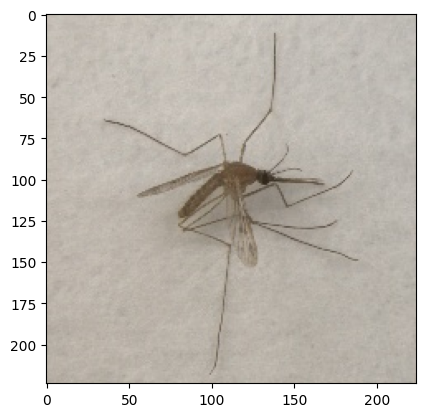

In [10]:
# looking at a random image

plt.imshow(image.load_img(np.random.choice(image_files)))
plt.show()

Fitting the model

In [11]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, Add, BatchNormalization, ReLU, GlobalAveragePooling2D, Reshape, Dense, Multiply, MaxPooling2D, Dropout, LayerNormalization, Concatenate, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_normal

from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, MaxPooling2D, GlobalAveragePooling2D, Dense, Add, Concatenate

def MBConvBlock(input_tensor, expansion_ratio, output_filters, kernel_size, strides, se_ratio=None):
    # Expansion phase
    expanded_filters = expansion_ratio * input_tensor.shape[-1]
    x = Conv2D(expanded_filters, kernel_size=(1, 1), padding='same', strides=(1, 1))(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Depthwise convolution
    x = DepthwiseConv2D(kernel_size=kernel_size, strides=strides, padding='same')(x)
    x = BatchNormalization()(x)
    x = ReLU()(x)

    # Squeeze-and-Excitation (SE) block (optional)
    if se_ratio:
        se_filters = max(1, int(input_tensor.shape[-1] * se_ratio))
        se = GlobalAveragePooling2D()(x)
        se = Reshape((1, 1, expanded_filters))(se)
        se = Conv2D(se_filters, kernel_size=(1, 1), padding='same', activation='relu')(se)
        se = Conv2D(expanded_filters, kernel_size=(1, 1), padding='same', activation='sigmoid')(se)
        x = Multiply()([x, se])

    # Output phase
    x = Conv2D(output_filters, kernel_size=(1, 1), padding='same', strides=(1, 1))(x)
    if input_tensor.shape[-1] == output_filters and strides == (1, 1):
        x = Add()([x, input_tensor])  # Residual connection
    return x

def residual_block(input_tensor, filters):
    shortcut = input_tensor
    x = Conv2D(filters, (3, 3), padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(filters, (3, 3), padding='same')(x)
    x = BatchNormalization()(x)
    if input_tensor.shape[-1] != filters:
        shortcut = Conv2D(filters, (1, 1), padding='same')(input_tensor)
    x = Add()([x, shortcut])  # Residual connection
    x = ReLU()(x)
    return x

def blockB(input_tensor, filters):
    X = Conv2D(filters, (1, 1), padding='same')(input_tensor)
    X = Conv2D(filters * 2, (5, 5), padding='same')(X)
    X = Conv2D(filters, (1, 1), padding='same')(X)
    X = BatchNormalization()(X)

    Y = Conv2D(filters, (1, 1), padding='same')(input_tensor)
    Y = Conv2D(filters * 2, (3, 3), padding='same')(Y)
    Y = Conv2D(filters, (3, 3), padding='same')(Y)

    Z = Conv2D(filters, (1, 1), padding='same')(input_tensor)

    combined = Concatenate(axis=-1)([X, Y, Z])
    W = Conv2D(filters, (1, 1), padding='same', activation='relu')(combined)
    W = BatchNormalization()(W)
    W = MaxPooling2D((2, 2))(W)

    return W

def spatial_attention_block(input_tensor):
    """
    Spatial Attention Block

    Args:
        input_tensor (Tensor): Input tensor with shape (batch_size, height, width, channels)

    Returns:
        Tensor: Output tensor with spatial attention applied
    """
    # Compute the maximum value across channels for each spatial location
    attn_mask = Lambda(lambda x: tf.reduce_max(x, axis=-1, keepdims=True))(input_tensor)

    # Apply a 1x1 convolution, batch normalization, and ReLU activation
    attn_mask = Conv2D(1, (1, 1), padding='same', kernel_initializer=he_normal())(attn_mask)
    attn_mask = BatchNormalization()(attn_mask)
    attn_mask = ReLU()(attn_mask)

    # Apply sigmoid activation to get the attention mask
    attn_mask = tf.nn.sigmoid(attn_mask)

    # Multiply the input tensor with the attention mask
    output_tensor = Multiply()([input_tensor, attn_mask])

    return output_tensor

def inception_block(input_tensor, filters, kernel_sizes=(1, 3, 5)):
    """
    Inception-like Block

    Args:
        input_tensor (Tensor): Input tensor
        filters (int): Number of filters for each convolutional layer
        kernel_sizes (tuple or list): Kernel sizes for the convolutional layers (default: (1, 3, 5))

    Returns:
        Tensor: Output tensor after the Inception-like block
    """
    conv_layers = []

    # Apply convolutional layers with different kernel sizes
    for kernel_size in kernel_sizes:
        conv = Conv2D(filters, (kernel_size, kernel_size), padding='same', kernel_initializer=he_normal())(input_tensor)
        conv_layers.append(conv)

    # Concatenate the outputs of the convolutional layers along the channel axis
    x = Concatenate(axis=-1)(conv_layers)

    # Apply batch normalization and ReLU activation
    x = BatchNormalization()(x)
    x = ReLU()(x)

    return x


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, DepthwiseConv2D, Add, BatchNormalization, ReLU, GlobalAveragePooling2D,Flatten, Reshape, Dense, Multiply, MaxPooling2D, Dropout, LayerNormalization, Concatenate, Flatten, Lambda
from tensorflow.keras.models import Model
from tensorflow.keras.initializers import he_normal
from tensorflow.keras.regularizers import l2

# Define the input
inputs = Input(shape=(128, 128, 3))

# Initial Conv Layer
x = Conv2D(32, (3, 3), padding='same', kernel_initializer=he_normal())(inputs)
x = BatchNormalization()(x)
x = ReLU()(x)

# Spatial Attention Block
x = spatial_attention_block(x)

# Residual Block
x = residual_block(x, filters=64)
x = MaxPooling2D((2, 2))(x)  # Add max-pooling after the residual block

# Inception-like Block
x = inception_block(x, filters=32)

# MBConv Block
x = MBConvBlock(x, expansion_ratio=6, output_filters=64, kernel_size=(3, 3), strides=(1, 1), se_ratio=0.25)

# Residual Block
x = residual_block(x, filters=32)
x = MaxPooling2D((2, 2))(x)  # Add max-pooling after the residual block

# Inception-like Block
x = inception_block(x, filters=16)

# MBConv Block
x = MBConvBlock(x, expansion_ratio=6, output_filters=32, kernel_size=(3, 3), strides=(1, 1), se_ratio=0.25)

# # Spatial Attention Block
# x = spatial_attention_block(x)

# Global Average Pooling
x = GlobalAveragePooling2D()(x)
# x = Flatten()(x)

# Dense layers
# x = Dense(256, activation='relu', kernel_regularizer=l2(0.001))(x)
# x = Dropout(0.2)(x)
x = Dense(16, activation='relu', kernel_regularizer=l2(0.001))(x)
x = Dropout(0.2)(x)

# Output layer (assuming 'folders' contains class labels)
prediction = Dense(len(folders), activation='softmax')(x)

# Create the final model
model = Model(inputs=inputs, outputs=prediction)

# Print the model summary
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 128, 128, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 128, 128, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 128, 128, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 re_lu (ReLU)                (None, 128, 128, 32)         0         ['batch_normalization[0][0

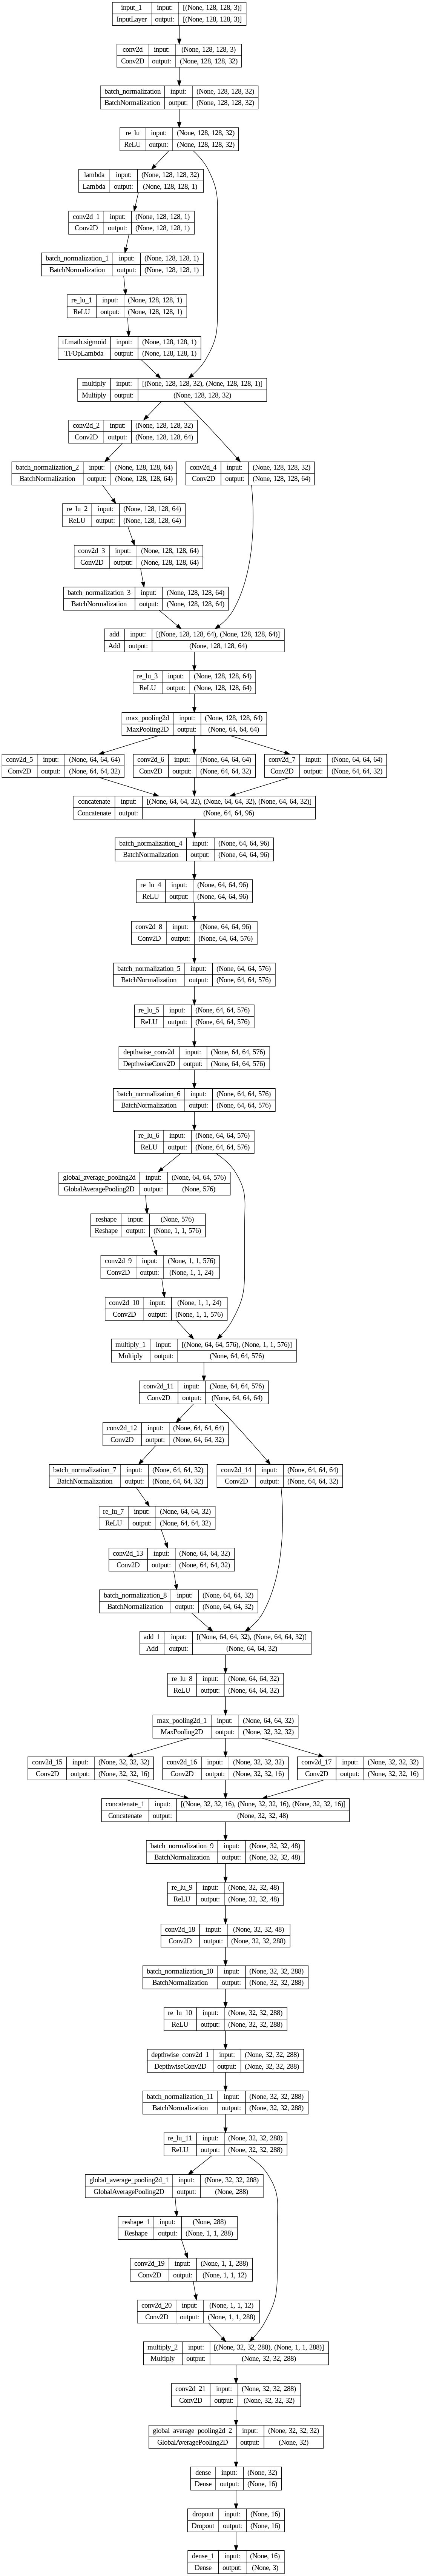

In [13]:
from tensorflow.keras.utils import plot_model

# Visualize the model architecture
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')

In [14]:
# from IPython.display import Image
# Image(filename='model.png')

In [15]:
from keras.optimizers import Adam,RMSprop,SGD,Adagrad,Adadelta,Nadam,AdamW


adam = Adam(
    learning_rate=0.001,  # Initial learning rate
    beta_1=0.9,           # Exponential decay rate for the first moment estimate
    beta_2=0.999,         # Exponential decay rate for the second moment estimate
    epsilon=1e-7,         # Small constant to prevent division by zero
    amsgrad=False         # Whether to apply the AMSGrad variant (True or False)
)


sgd = SGD(
    learning_rate=0.001,   # Initial learning rate
    momentum=0.009,         # Momentum factor (acceleration in the relevant direction)
    nesterov=False        # Whether to apply Nesterov momentum (True or False)
)
adagrad = Adagrad(
    learning_rate=0.01,   # Initial learning rate
    epsilon=1e-7          # Small constant to prevent division by zero
)
adadelta = Adadelta(
    learning_rate=1.0,     # Initial learning rate (default is 1.0)
    rho=0.95,              # Decay rate (similar to beta in RMSprop)
    epsilon=1e-7           # Small constant to prevent division by zero
)

nadam = Nadam(
    learning_rate=0.002,   # Initial learning rate
    beta_1=0.9,            # Exponential decay rate for the first moment estimate (Adam)
    beta_2=0.999,          # Exponential decay rate for the second moment estimate (Adam)
    epsilon=1e-7           # Small constant to prevent division by zero
)

rms = RMSprop(learning_rate=0.1, rho=0.9, momentum=0.0, epsilon=1e-7)
adamW = AdamW(learning_rate=1e-3, beta_1=0.9, beta_2=0.999, epsilon=1e-7, weight_decay=1e-2)


model.compile(
    loss = 'categorical_crossentropy',
    optimizer=adamW,
    metrics = ['accuracy']
)


**Creating the Image to feed into the model**

In [16]:
# choose one which one is used

# from keras.applications.vgg16 import preprocess_input
# from keras.applications.vgg19 import preprocess_input
# from keras.applications.resnet50 import preprocess_input
# from keras.applications.resnet import preprocess_input
# from keras.applications.resnet import preprocess_input
# from keras.applications.xception import preprocess_input
# from keras.applications.inception_v3 import preprocess_input
# from keras.applications.inception_resnet_v2 import preprocess_input
from keras.applications.mobilenet import preprocess_input
# from keras.applications.mobilenet_v2 import preprocess_input
# from keras.applications.densenet import preprocess_input
# from keras.applications.nasnet import preprocess_input
# from keras.applications.efficientnet import preprocess_input

In [17]:
gen = ImageDataGenerator(
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    preprocessing_function=preprocess_input
)

Found 300 images belonging to 3 classes.


{'AEDES': 0, 'ANOPHELES': 1, 'CULEX': 2}
min: -0.81661105 max: 0.55948925


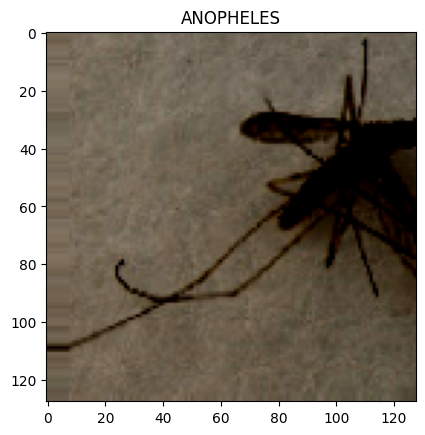

In [18]:
# testing the generator to see how it works and some other usefull things

# get label mapped for confusion matrix plot later
test_gen = gen.flow_from_directory(val_path, target_size = IMAGE_SIZE)
print(test_gen.class_indices)
labels = [None]* len(test_gen.class_indices)
for k,v in test_gen.class_indices.items():
  labels[v]=k

# should be strangely colored image (sue to VGG weights being BGR)
for x,y in test_gen:
  print("min:",x[0].min(), "max:", x[0].max())
  plt.title(labels[np.argmax(y[0])])
  plt.imshow(x[0])
  plt.show()
  break


In [19]:
#create generator

train_generator = gen.flow_from_directory(
    train_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

val_generator = gen.flow_from_directory(
    val_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)

Found 2400 images belonging to 3 classes.
Found 300 images belonging to 3 classes.


Including callbacks

In [20]:
import tensorflow as tf
from keras.callbacks import (
    EarlyStopping,
    ModelCheckpoint,
    TensorBoard,
    ReduceLROnPlateau,
    CSVLogger,
    LearningRateScheduler,
)
import datetime

# Define early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=20)

# Define model checkpointing
model_checkpoint = ModelCheckpoint(
    "best_model.h5", monitor="val_loss", save_best_only=True
)

# Define TensorBoard callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(
    log_dir=log_dir, histogram_freq=1, update_freq="epoch"
)

# Define ReduceLROnPlateau callback
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.2, patience=10, min_lr=1e-6)

# Define CSVLogger callback
csv_logger = tf.keras.callbacks.CSVLogger("training.log")


# Define LearningRateScheduler callback
def lr_scheduler(epoch, lr):
    if epoch % 10 == 0:
        return lr * 0.9
    else:
        return lr


lr_scheduler_callback = LearningRateScheduler(lr_scheduler)

# Combine all callbacks
callbacks = [
    early_stopping,
    model_checkpoint,
    tensorboard_callback,
    reduce_lr,
    csv_logger,
    lr_scheduler_callback,
]

Integrating tensorboard

In [21]:
# # Clear any logs from previous runs
# !rm -rf ./logs/

In [22]:
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit

In [23]:
r = model.fit(
    train_generator,
    validation_data=val_generator,
    epochs=50,  # Increase the number of epochs
    steps_per_epoch=len(image_files) // batch_size,
    validation_steps=len(val_image_files) // batch_size,
    callbacks=callbacks,  # Add callbacks here
    verbose=1
)

Epoch 1/50
75/75 [==============================] - ETA: 0s - loss: 0.3245 - accuracy: 0.8917

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


75/75 [==============================] - 79s 421ms/step - loss: 0.3245 - accuracy: 0.8917 - val_loss: 1.1240 - val_accuracy: 0.3333 - lr: 9.0000e-04
Epoch 2/50
75/75 [==============================] - 23s 301ms/step - loss: 0.1575 - accuracy: 0.9563 - val_loss: 1.1521 - val_accuracy: 0.3368 - lr: 9.0000e-04
Epoch 3/50
75/75 [==============================] - 26s 340ms/step - loss: 0.1716 - accuracy: 0.9533 - val_loss: 1.2447 - val_accuracy: 0.3264 - lr: 9.0000e-04
Epoch 4/50
75/75 [==============================] - 25s 337ms/step - loss: 0.1102 - accuracy: 0.9712 - val_loss: 1.6644 - val_accuracy: 0.3264 - lr: 9.0000e-04
Epoch 5/50
75/75 [==============================] - 24s 312ms/step - loss: 0.0719 - accuracy: 0.9829 - val_loss: 0.6815 - val_accuracy: 0.6736 - lr: 9.0000e-04
Epoch 6/50
75/75 [==============================] - 22s 297ms/step - loss: 0.0981 - accuracy: 0.9771 - val_loss: 0.1511 - val_accuracy: 0.9618 - lr: 9.0000e-04
Epoch 7/50
75/75 [==============================] -

In [24]:
# evaluate model

from tensorflow.keras.models import load_model


test_generator = gen.flow_from_directory(
    test_path,
    target_size = IMAGE_SIZE,
    shuffle = True,
    batch_size = batch_size
)


model = load_model('best_model.h5')
evaluation = model.evaluate(train_generator)
evaluation = model.evaluate(val_generator)
evaluation = model.evaluate(test_generator)

Found 300 images belonging to 3 classes.
10/10 [==============================] - 2s 194ms/step - loss: 0.0090 - accuracy: 1.0000


In [ ]:
# making a confusion matrix

def get_confusion_matrix(data_path,N):
  # we need to see the data in the same order
  # for both predictions and targets
  print("Generating confusion matrix" , N)
  predictions = []
  targets = []
  i = 0
  for x,y in gen.flow_from_directory(data_path, target_size=IMAGE_SIZE, shuffle = False, batch_size=batch_size*2):
    i+=1
    if i%50 ==0:
      print(i)
    p = model.predict(x)
    p = np.argmax(p, axis =1)
    y = np.argmax(y, axis = 1)
    predictions = np.concatenate((predictions,p))
    targets = np.concatenate((targets,y))
    if len(targets)>=N:
      break

  cm = confusion_matrix(targets,predictions)
  return cm


In [26]:
train_cm = get_confusion_matrix(train_path, len(image_files))
print(train_cm)

Generating confusion matrix 2400
Found 2400 images belonging to 3 classes.
1/1 [==============================] - 0s 25ms/step
[[800   0   0]
 [  0 800   0]
 [  0   0 800]]


In [ ]:
val_cm = get_confusion_matrix(val_path, len(val_image_files))
print(val_cm)

In [ ]:
test_cm = get_confusion_matrix(test_path, len(test_image_files))
print(test_cm)

In [29]:
cm = test_cm
# Calculate the total number of predictions
total_predictions = np.sum(cm)

# Calculate the number of correct predictions
correct_predictions = np.trace(cm)

# Calculate Accuracy
accuracy = correct_predictions / total_predictions

# Calculate Precision, Recall, F1-score for each class
precision = np.diag(cm) / np.sum(cm, axis=0)
recall = np.diag(cm) / np.sum(cm, axis=1)
f1_score = 2 * precision * recall / (precision + recall)

print("Accuracy: ", accuracy)
print("Precision: ", precision)
print("Recall: ", recall)
print("F1-score: ", f1_score)

Accuracy:  1.0
Precision:  [1. 1. 1.]
Recall:  [1. 1. 1.]
F1-score:  [1. 1. 1.]


9/9 [==============================] - 3s 253ms/step


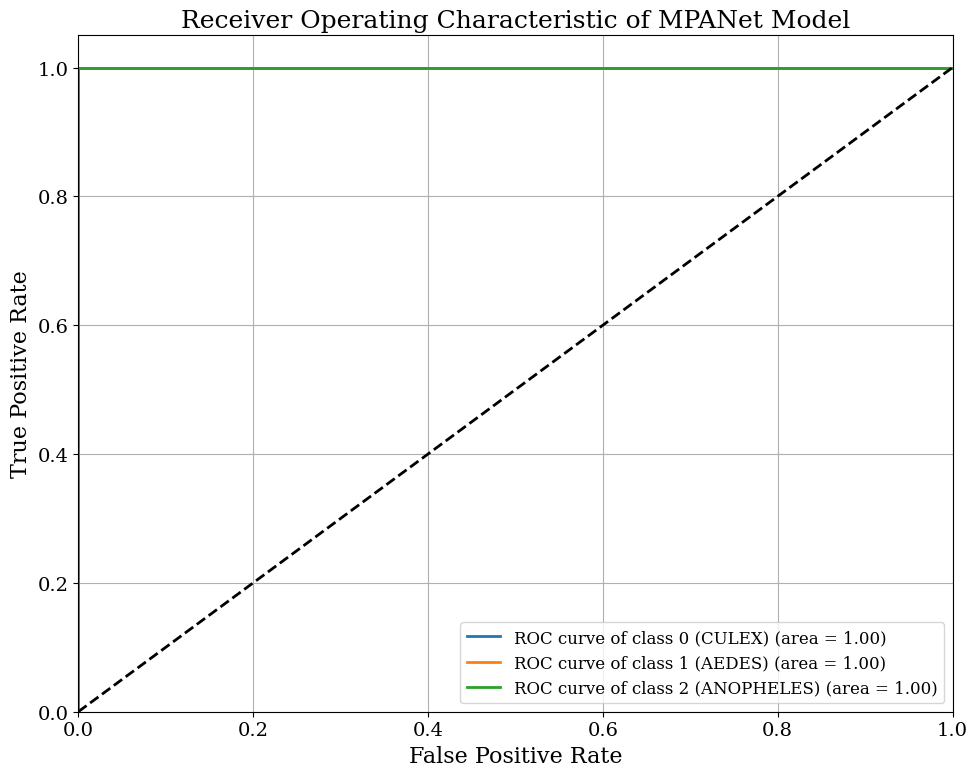

In [30]:
import numpy as np
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt
from itertools import cycle
from matplotlib import rcParams

# Set up font properties
rcParams['font.family'] = 'serif'
rcParams['font.size'] = 14

# Assuming test_generator is defined as in your initial code
# Get true labels and predicted probabilities
test_steps = test_generator.samples // test_generator.batch_size
true_labels = np.concatenate([train_generator[i][1] for i in range(test_steps)])
pred_probs = model.predict(train_generator, steps=test_steps)

# Binarize the true labels for ROC
num_classes = len(test_generator.class_indices)
true_labels_binarized = label_binarize(true_labels, classes=list(range(num_classes)))

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(num_classes):
    fpr[i], tpr[i], _ = roc_curve(true_labels_binarized[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Define class names
class_names = ['CULEX', 'AEDES', 'ANOPHELES']

# Plot all ROC curves
plt.figure(figsize=(10, 8))
colors = cycle(['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2'])

for i, color in zip(range(num_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=2,
             label='ROC curve of class {0} ({1}) (area = {2:0.2f})'
                   ''.format(i, class_names[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=2)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', fontsize=16)
plt.ylabel('True Positive Rate', fontsize=16)
plt.title('Receiver Operating Characteristic of MPANet Model', fontsize=18)
plt.legend(loc="lower right", fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.savefig('multiclass_roc_curves.png')
plt.show()

In [31]:
import pandas as pd

# Assuming class names are based on the order of the folders
class_names = ['CULEX', 'AEDES', 'ANOPHELES']
n_classes = len(folders)
misclassifications = {}
for i in range(n_classes):
    misclassified = sum(test_cm[i][j] for j in range(n_classes) if j != i)
    total = sum(test_cm[i])
    class_name = class_names[i]
    misclassifications[f'Misclassifications ({class_name})'] = misclassified

print(misclassifications)

{'Misclassifications (CULEX)': 0, 'Misclassifications (AEDES)': 0, 'Misclassifications (ANOPHELES)': 0}


In [32]:
import pandas as pd

# Assuming class names are based on the order of the folders
class_names = ['CULEX', 'AEDES', 'ANOPHELES']
n_classes = len(folders)


avg_misclassification = {}
for i in range(n_classes):
    misclassified = sum(cm[i][j] for j in range(n_classes) if j != i)
    total = sum(cm[i])
    class_name = class_names[i]
    avg_misclassification[f'Avg Misclassification Rate ({class_name})'] = misclassified / total

df_misclassification = pd.DataFrame([avg_misclassification])
df_misclassification

,Avg Misclassification Rate (CULEX),Avg Misclassification Rate (AEDES),Avg Misclassification Rate (ANOPHELES)
0,0.0,0.0,0.0


Plotting some data

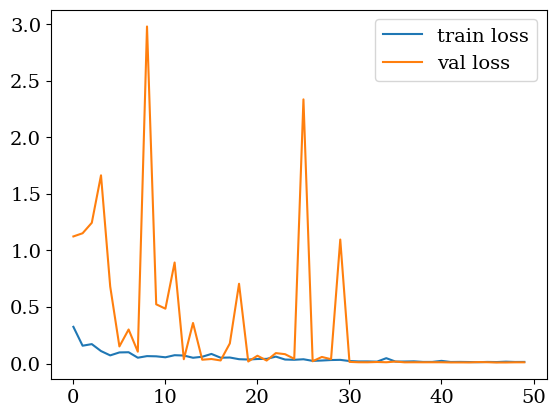

In [33]:
#loss

plt.plot(r.history['loss'],label = 'train loss')
plt.plot(r.history['val_loss'],label = 'val loss')
plt.legend()
plt.show()

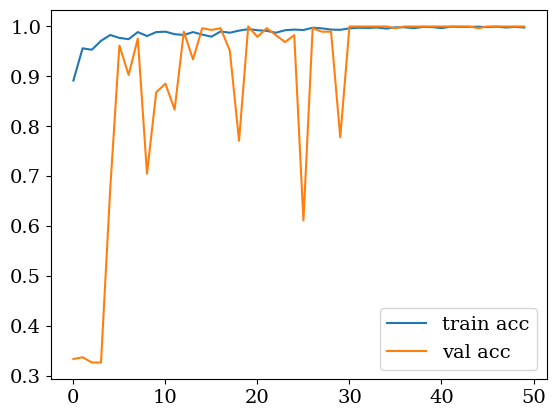

In [34]:
# acccuracy

plt.plot(r.history['accuracy'],label = 'train acc')
plt.plot(r.history['val_accuracy'],label = 'val acc')
plt.legend()
plt.show()


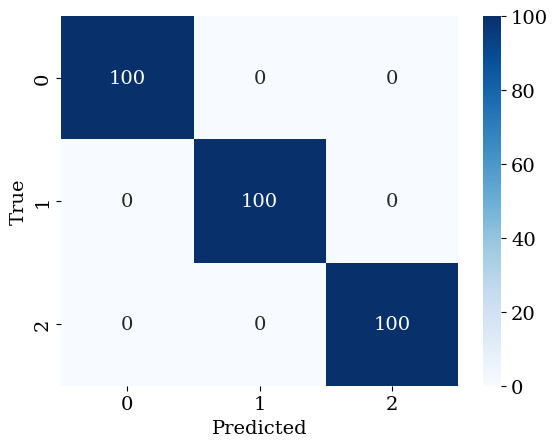

In [35]:
# visualising training cm
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

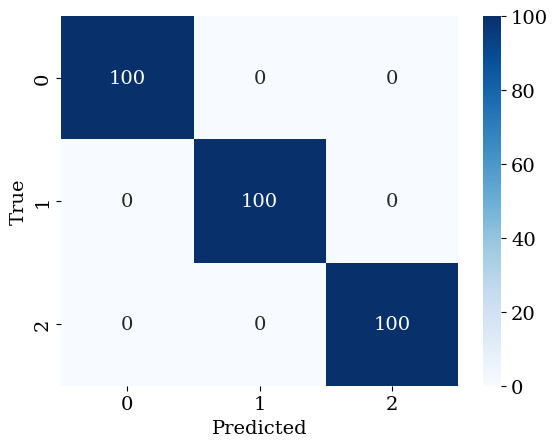

In [36]:
# visualising validation cm
sns.heatmap(val_cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

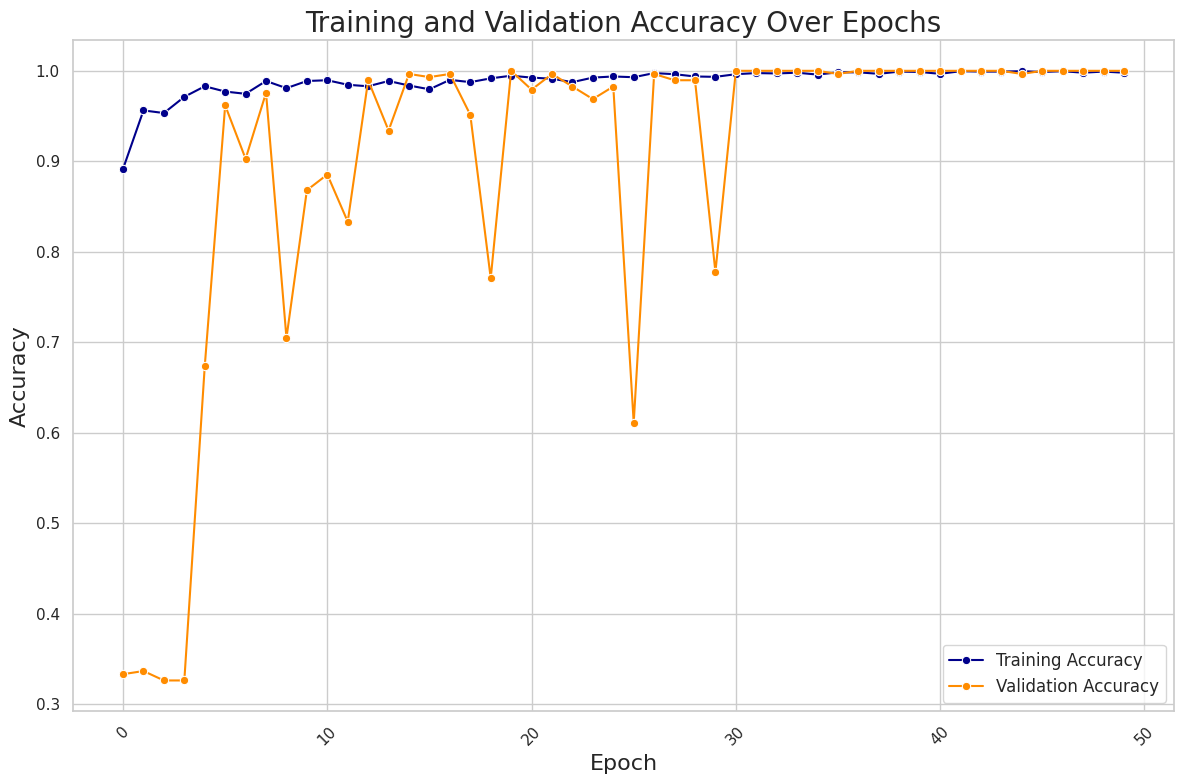

In [37]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read log file into a DataFrame
log_file_path = 'training.log'
df = pd.read_csv(log_file_path)

# Set a visually pleasing Seaborn style
sns.set(style="whitegrid")

# Create a larger figure
plt.figure(figsize=(12, 8))

# Create a line plot with Seaborn using a different color palette
sns.lineplot(x='epoch', y='accuracy', data=df, label='Training Accuracy', color='darkblue', marker='o')
sns.lineplot(x='epoch', y='val_accuracy', data=df, label='Validation Accuracy', color='darkorange', marker='o')

# Customize plot aesthetics
plt.title('Training and Validation Accuracy Over Epochs', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.legend(fontsize=12)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Use tight layout
plt.tight_layout()

# Display the plot
plt.show()


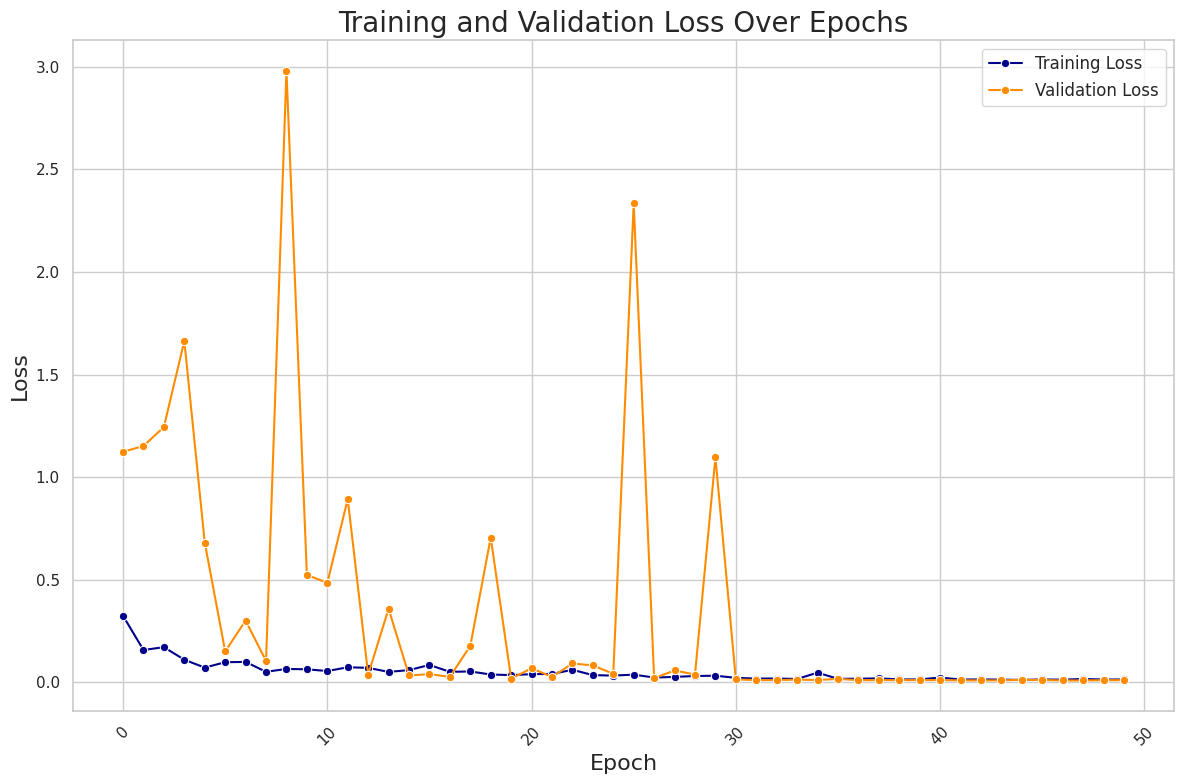

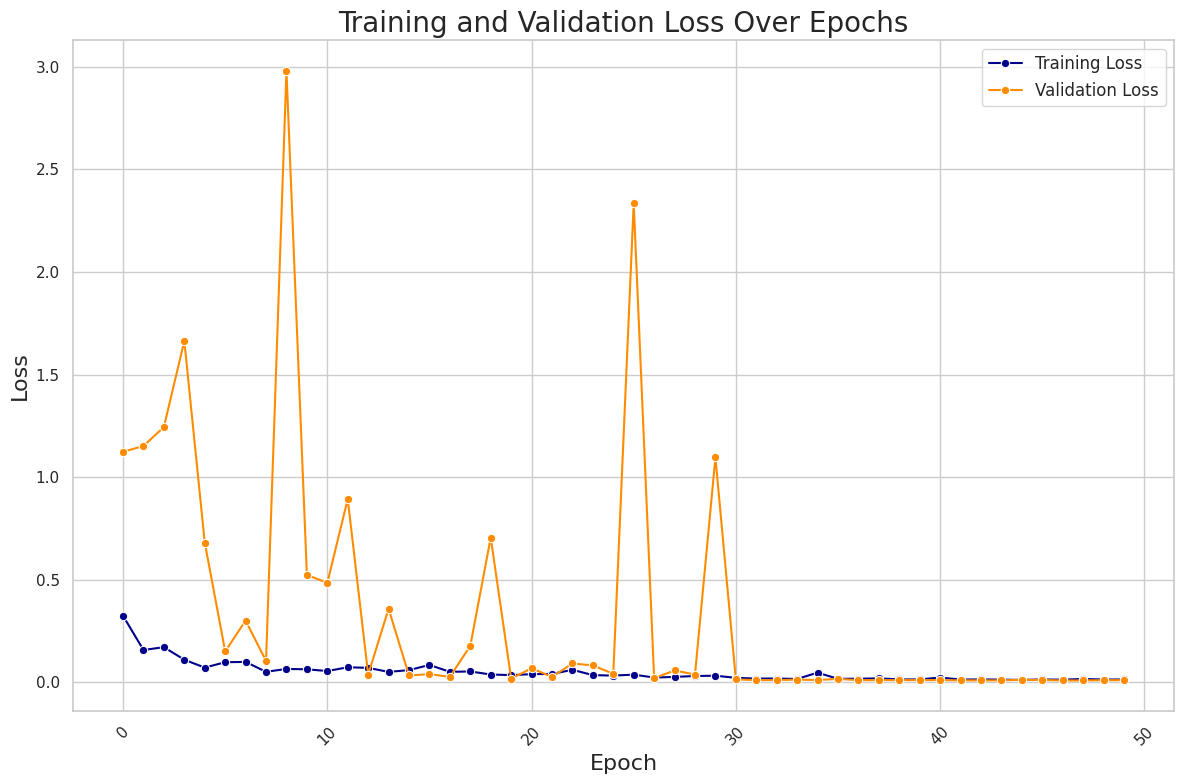

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Read log file into a DataFrame
log_file_path = 'training.log'
df = pd.read_csv(log_file_path)

# Set a visually pleasing Seaborn style
sns.set(style="whitegrid")

# Create a larger figure
plt.figure(figsize=(12, 8))

# Create a line plot with Seaborn using a different color palette
sns.lineplot(x='epoch', y='loss', data=df, label='Training Loss', color='darkblue', marker='o')
sns.lineplot(x='epoch', y='val_loss', data=df, label='Validation Loss', color='darkorange', marker='o')

# Customize plot aesthetics
plt.title('Training and Validation Loss Over Epochs', fontsize=20)
plt.xlabel('Epoch', fontsize=16)
plt.ylabel('Loss', fontsize=16)
plt.legend(fontsize=12)

# Rotate x-axis labels if necessary
plt.xticks(rotation=45)

# Use tight layout
plt.tight_layout()

# Display the plot
plt.show()
